In [1]:
from sklearn.ensemble import VotingClassifier
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression


In [2]:
def read_csv_file(file_path):
    """
    Reads a CSV file and returns its content as a pandas DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except ValueError as e:
        print(f"Error reading CSV file: {e}")
        return None
    
    

# Chargement des données
train_data = pd.read_csv('data/train_data_80.csv')
descriptors = train_data.iloc[:, 1:200]
smiles = train_data.iloc[:, 0]  
fingerprints = train_data.iloc[:, 200:-1]
labels = train_data.iloc[:, -1]

test_data = pd.read_csv('data/train_data_20.csv')
descriptors_test = test_data.iloc[:, 1:200]
smiles_test = test_data.iloc[:, 0]
fingerprints_test = test_data.iloc[:, 200:-1]
labels_test = test_data.iloc[:, -1]


In [3]:
def load_probas_from_csv(file_path):
    """
    Loads probabilities from a CSV file and returns them as a numpy array.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except ValueError as e:
        print(f"Error reading probabilities CSV file: {e}")
        return None

## reg log fingerprints

In [4]:
gcn_prob = load_probas_from_csv('predictions/gcn_proba.csv')
reg_prob = load_probas_from_csv('predictions/reg_log_proba.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba.csv')


probas_df = gcn_prob.merge(reg_prob, on='smiles').merge(xgb_prob, on='smiles')
probas_df.columns = ['smiles', 'gcn_prob', 'reg_prob', 'xgb_prob']

print(probas_df.head())
print(probas_df.shape)

                                              smiles  gcn_prob  reg_prob  \
0  CCn1c(=O)oc2ccc(-c3ccc(CC(C#N)NC(=O)C4CNCCCO4)...  0.089505  0.509066   
1  O=C(O)CCCCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5...  0.785084  0.003511   
2    CNC(=O)c1ccc(-c2ccc3c(c2)CCN(CCN2CCCC2)C3=O)cc1  0.643717  0.928476   
3  CCN(CC)c1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(...  0.931346  0.671753   
4            c1cncc(C(Cc2ccccc2-c2ccncc2)c2cccnc2)c1  0.071936  0.682976   

   xgb_prob  
0  0.077500  
1  0.222387  
2  0.218100  
3  0.748372  
4  0.215649  
(384, 4)


In [5]:
X = probas_df[['gcn_prob', 'reg_prob', 'xgb_prob']].values
y_pred = (np.mean(X, axis=1) > .5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
print(f"Predictions: {y_pred[:10]}")



_,  y_test = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels)

y_test = y_test.values
print(f"Labels shape: {y_test.shape}")
print(f"Labels: {y_test[:10]}")

print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))


kappa_score = cohen_kappa_score(y_pred, y_test)
print(f"Cohen's Kappa Score: {kappa_score}")


# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()


Predictions shape: (384,)
Predictions: [0 0 1 1 0 0 1 1 1 0]
Labels shape: (1507,)
Labels: [0 0 0 0 0 1 0 1 1 1]


Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [1507, 384]

In [ ]:
def save_to_csv(df, file_path):
    """
    Saves a DataFrame to a CSV file.
    """
    try:
        df.to_csv(file_path, index=False)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving DataFrame to CSV: {e}")

In [ ]:
meta_X = pd.concat([probas_df[['gcn_prob', 'reg_prob', 'xgb_prob']], labels], axis=1)
print(f"Meta X shape: {meta_X.shape}")
print(f"Meta X head:\n{meta_X.head()}")

Meta X shape: (9415, 4)
Meta X head:
   gcn_prob  reg_prob  xgb_prob  class
0  0.168103  0.096144  0.067245      0
1  0.022399  0.023414  0.092872      0
2  0.429374  0.706475  0.846492      1
3  0.960706  0.984383  0.978015      1
4  0.804549  0.941262  0.987505      0


In [ ]:
save_to_csv(meta_X, 'data/probas.csv')

Data saved to data/probas.csv


## LGBM fingerprints

In [ ]:
gcn_prob = load_probas_from_csv('predictions/gcn_proba.csv')
lgb_prob = load_probas_from_csv('predictions/lgbm_proba.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba.csv')


probas_df = gcn_prob.merge(lgb_prob, on='smiles').merge(xgb_prob, on='smiles')
probas_df.columns = ['smiles', 'gcn_prob', 'lgb_prob', 'xgb_prob']

print(probas_df.head())
print(probas_df.shape)

                                              smiles  gcn_prob  lgb_prob  \
0   O=C(O)C1(F)CCN(C2CCC3(Cc4ccccc4Cc4ccccc43)C2)CC1  0.168103  0.036781   
1  Cc1nc2ccccc2n1C1CC2CCC(C1)N2CCC1(c2ccccc2)CCN(...  0.022399  0.021694   
2  NC1(C(=O)NC(c2ccc(Cl)cc2)C2CC2)CCN(c2ncnc3[nH]...  0.429374  0.877608   
3  CC(c1ccc(OCCCN2CCC(c3noc4cc(F)ccc34)CC2)cc1)c1...  0.960706  0.995049   
4               C(CN1CCCCCC1)=C1CCCc2c1cnn2-c1ccccc1  0.804549  0.992333   

   xgb_prob  
0  0.067245  
1  0.092872  
2  0.846492  
3  0.978015  
4  0.987505  
(1883, 4)


Predictions shape: (1883,)
Predictions: [0 0 1 1 1 0 0 1 1 1]
Labels shape: (1883,)
Labels: [0 0 1 1 1 0 0 1 1 1]


Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8940    0.8804    0.8872       920
     Class 1     0.8874    0.9003    0.8938       963

    accuracy                         0.8906      1883
   macro avg     0.8907    0.8904    0.8905      1883
weighted avg     0.8906    0.8906    0.8906      1883

Cohen's Kappa Score: 0.7810116534693375


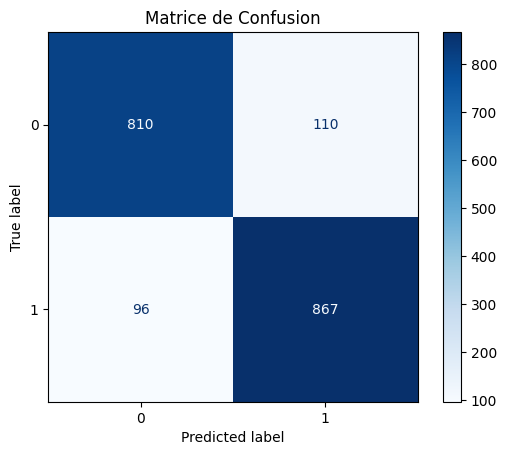

In [ ]:
X = probas_df[['gcn_prob', 'lgb_prob', 'xgb_prob']].values
y_pred = (np.mean(X, axis=1) > .5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
print(f"Predictions: {y_pred[:10]}")



_,  y_test = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels)

y_test = y_test.values
print(f"Labels shape: {y_test.shape}")
print(f"Labels: {y_test[:10]}")

print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))


kappa_score = cohen_kappa_score(y_pred, y_test)
print(f"Cohen's Kappa Score: {kappa_score}")


# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()


## RF Fingerprints (retenu pour la première prédiction)

In [ ]:
gcn_prob = load_probas_from_csv('predictions/gcn_proba.csv')
rf_prob = load_probas_from_csv('predictions/rf_proba.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba.csv')
smiles_prob = load_probas_from_csv('predictions/smiles_proba.csv')


probas_df = gcn_prob.merge(rf_prob, on='smiles').merge(xgb_prob, on='smiles').merge(smiles_prob, on='smiles')
probas_df.columns = ['smiles', 'gcn_prob', 'rf_prob', 'xgb_prob', 'smiles_prob']

print(probas_df.head())
print(probas_df.shape)

                                              smiles  gcn_prob   rf_prob  \
0  O=C(O)C(Cc1ccccc1)N1CCC(CN2CCC(Oc3ccc(CO)c(Cl)...  0.030622  0.155556   
1  CN1CCN(CCCn2nc(C3=C(c4cn(-c5ccc6ccccc6c5)c5ccc...  0.931967  0.915556   
2  OCC1(N2CCN(C3CCc4ccc(OCc5noc(-c6ccc(Cl)cc6)n5)...  0.957408  0.853333   
3  CCn1c(=O)oc2ccc(-c3ccc(CC(C#N)NC(=O)C4CNCCCO4)...  0.089505  0.097778   
4  O=C(C1CC1c1ccc(C(F)(F)F)cc1)N1CCN(S(=O)(=O)c2c...  0.940113  0.933333   

   xgb_prob  smiles_prob  
0  0.049748     0.041841  
1  0.918788     0.467382  
2  0.921973     0.946834  
3  0.088541     0.087658  
4  0.978391     0.954703  
(1883, 5)


Predictions shape: (1883,)
Labels shape: (1883,)


Classification Report:
              precision    recall  f1-score   support

     Class 0     0.7919    0.8308    0.8109       916
     Class 1     0.8319    0.7932    0.8121       967

    accuracy                         0.8115      1883
   macro avg     0.8119    0.8120    0.8115      1883
weighted avg     0.8124    0.8115    0.8115      1883

Cohen's Kappa Score: 0.6231535105497172


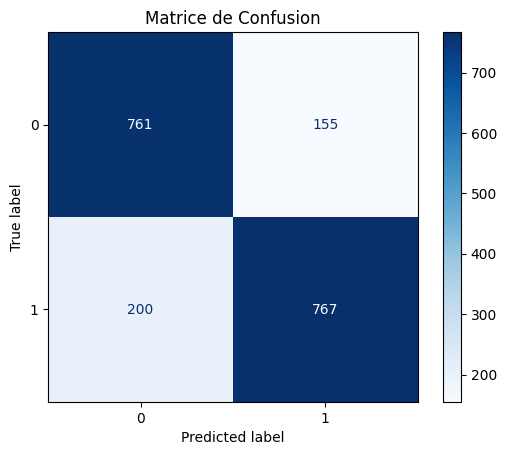

In [ ]:
X = probas_df[['gcn_prob', 'rf_prob', 'xgb_prob', 'smiles_prob']].values
y_pred_proba = np.mean(X, axis=1)
y_pred = (y_pred_proba > .5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
# print(f"Predictions: {y_pred[:10]}")


y_test = labels_test.values

print(f"Labels shape: {y_test.shape}")
# print(f"Labels: {y_test[:10]}")

print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))


kappa_score = cohen_kappa_score(y_pred, y_test)
print(f"Cohen's Kappa Score: {kappa_score}")


# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()


### Trier les 200 premiers en fonctions de la confiance

                                                smiles      diff  pred  true
317  Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(OC(F)(F)F)c...  0.004726     1     1
282  Cn1c(CCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)nnc1-c...  0.005418     1     1
308  Cc1ncoc1-c1nnc(SCCCN2CCC3(CC3c3ccccc3C(F)(F)F)...  0.006625     1     1
146  Cc1ccc2c(-c3nnc(SCCCN4CCc5ccc6oc(C(F)(F)C(F)(F...  0.007342     1     1
370  Cn1c(SCCCN2CC3CCN(c4ccc(C(F)(F)F)cc4)C3C2)nnc1...  0.007793     1     1
..                                                 ...       ...   ...   ...
206  Fc1ccc(OCc2cc(OCC3(F)COC3)nc(-c3ccccn3)n2)c(F)c1F  0.491786     0     1
64        O=C(C1CC(Oc2cccc(Cl)c2)CN1)N1CCCN(C2CCC2)CC1  0.492694     0     1
286  Nc1ccc(-c2cccs2)cc1NC(=O)c1ccc(C(=O)N2CCC3(CCC...  0.496466     0     0
105  Cc1noc(C2CC2C(=O)NCc2ccc(-c3cccc(OC(F)(F)F)c3)...  0.497326     1     1
337  CCNC(=O)Nc1cccc(CNc2cc(C(F)(F)F)cc3ncc(N4CCN(C...  0.497381     1     0

[372 rows x 4 columns]


Classification Report:
              precision    

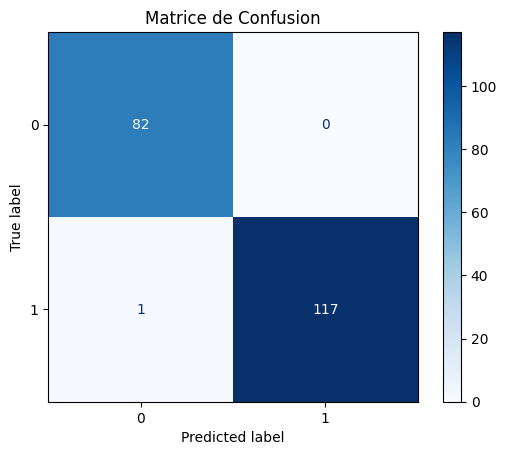

In [ ]:
y_dist = pd.DataFrame({
    'smiles': probas_df['smiles'],
    'diff': np.abs(y_pred_proba - y_pred),
    'pred': y_pred,
    'true': y_test
})

# Trier le DataFrame par ordre croissant des différences
y_dist_sorted = y_dist.sort_values(by='diff')

# Afficher le DataFrame trié
print(y_dist_sorted)

y_pred_200 = y_dist_sorted['pred'].head(200).values

y_test_200 = y_dist_sorted['true'].head(200).values


print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_pred=y_pred_200, y_true=y_test_200, target_names=['Class 0', 'Class 1'], digits=4))


kappa_score = cohen_kappa_score(y_pred_200, y_test_200)
print(f"Cohen's Kappa Score: {kappa_score}")


# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test_200, y_pred_200)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()



# Modèle d'ensemble

In [ ]:
gcn_prob = load_probas_from_csv('predictions/gcn_proba.csv')
ensemble_prob = load_probas_from_csv('predictions/ensemble_proba.csv')


probas_df = gcn_prob.merge(ensemble_prob, on='smiles')
probas_df.columns = ['smiles', 'gcn_prob', 'ensemble_prob']

print(probas_df.head())
print(probas_df.shape)

                                              smiles  gcn_prob  ensemble_prob
0   O=C(O)C1(F)CCN(C2CCC3(Cc4ccccc4Cc4ccccc43)C2)CC1  0.168103       0.059032
1  Cc1nc2ccccc2n1C1CC2CCC(C1)N2CCC1(c2ccccc2)CCN(...  0.022399       0.780465
2  NC1(C(=O)NC(c2ccc(Cl)cc2)C2CC2)CCN(c2ncnc3[nH]...  0.429374       0.840491
3  CC(c1ccc(OCCCN2CCC(c3noc4cc(F)ccc34)CC2)cc1)c1...  0.960706       0.141522
4               C(CN1CCCCCC1)=C1CCCc2c1cnn2-c1ccccc1  0.804549       0.787759
(1883, 3)


In [ ]:
X = probas_df[['gcn_prob', 'ensemble_prob']].values
y_pred = (np.mean(X, axis=1) > .5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
print(f"Predictions: {y_pred[:5]}")



_,  y_test = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Labels shape: {y_test.shape}")
print(f"Labels: {y_test[:5]}")




Predictions shape: (1883,)
Predictions: [0 0 1 1 1]
Labels shape: (1883,)
Labels: 8398    0
6219    0
7472    1
1104    1
36      1
Name: class, dtype: int64


In [ ]:
print(np.mean(y_pred == y_test))

0.7068507700477961


In [ ]:

kappa_score = cohen_kappa_score(y_pred, y_test.values)
print(f"Cohen's Kappa Score: {kappa_score}")

Cohen's Kappa Score: 0.4124831559241406


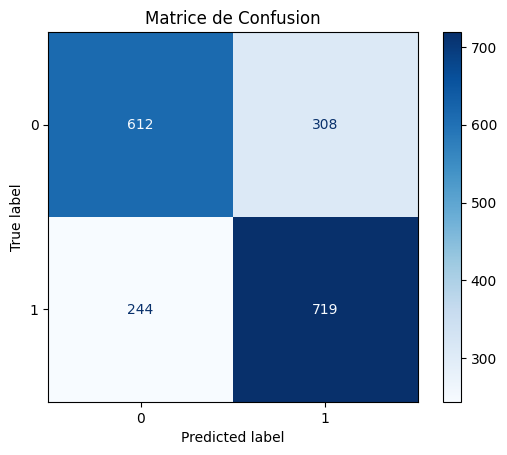

In [ ]:
# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# TEST 1

In [ ]:
# gcn_prob = load_probas_from_csv('predictions/gcn_proba_test_1.csv') # il ne sera pas retenu car smiles a de meilleurs résultats
rf_prob = load_probas_from_csv('predictions/rf_proba_test_1.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba_test_1.csv')
smiles_prob = load_probas_from_csv('predictions/smiles_proba_test_1.csv')


probas_df = rf_prob.merge(xgb_prob, on='smiles').merge(smiles_prob, on='smiles')
probas_df.columns = ['smiles', 'rf_prob', 'xgb_prob', 'smiles_prob']

print(probas_df.head())
print(probas_df.shape)

                                              smiles   rf_prob  xgb_prob  \
0                      Brc1cccc2nc(C#Cc3ccccn3)ccc12  0.217778  0.155712   
1           C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C  0.084444  0.053324   
2  C#CC1CCC(C#N)N1C(=O)CNC1(C)CCN(c2cc(C(=O)O)ccn...  0.168889  0.014513   
3                    C#CCN(C)CC1=Cc2ccccc2Oc2ccccc21  0.697778  0.627047   
4  C#Cc1cc(-c2n[nH]c3c2Cc2cc(CN4CCN(C)CC4)ccc2-3)cs1  0.857778  0.767996   

   smiles_prob  
0     0.264284  
1     0.071598  
2     0.031477  
3     0.834898  
4     0.877097  
(750, 4)


In [ ]:
X = probas_df[['rf_prob', 'xgb_prob', 'smiles_prob']].values
y_pred_proba = np.mean(X, axis=1)
y_pred = (y_pred_proba > .5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
print(f"Predictions: {y_pred[:10]}")
print(f"Predictions proba: {y_pred_proba[:10]}")



Predictions shape: (750,)
Predictions: [0 0 0 1 1 0 1 0 0 1]
Predictions proba: [0.21259108 0.06978893 0.07162645 0.71990753 0.83429033 0.47187415
 0.803932   0.31427094 0.26089681 0.70720121]


In [ ]:
y_dist = pd.DataFrame({
    'smiles': probas_df['smiles'],
    'diff': np.abs(y_pred_proba - y_pred),
    'class': y_pred
})

# Trier le DataFrame par ordre croissant des différences
y_dist_sorted = y_dist.sort_values(by='diff')

# Afficher le DataFrame trié
# print(y_dist_sorted.head(20))

y_pred_200 = y_dist_sorted['class'].head(200).values




y_final = y_dist_sorted.drop(columns=['diff'])

print(y_final.head(20))

save_to_csv(y_final, 'data/predictions_test_1.csv')




                                                smiles  class
246  CN(CCOc1ccc([N+](=O)[O-])cc1)CCc1ccc([N+](=O)[...      1
156                         CCCCN(CC)CC#CCCc1ccc(C)cc1      1
520     Fc1ccc2cccc(N3CCN(CCCOc4ccc5c(c4)CNC5)CC3)c2c1      1
541           N#Cc1ccc(CCN2CCN(CCc3ccc(C#N)cc3)CC2)cc1      1
431           Cc1ccc(CCc2cccc(CCc3ccc(C)cc3)[n+]2C)cc1      1
90                            CC(CS)C(=O)N1CCCC1C(=O)O      0
605        O=C(C=Cc1ccc2c(c1)CN(S(=O)(=O)c1cccs1)C2)NO      0
666                  O=C(c1ccccc1)C1CCN(CCc2ccccc2)CC1      1
130  CC1CN(C(=O)c2ccccc2)CCN1C(=O)C(=O)c1c[nH]c2cnc...      0
457               Cc1nc(-c2ccccc2)nc(OCCCN2CCCCC2)c1Cl      1
652         O=C(O)CC1COc2cc3c(cc21)OCC(c1cccc(Br)c1)O3      0
157                        CCCCN(CC)CC#CCOc1ccc(Cl)cc1      1
69                          CC(C)Cc1ccc(C(C)C(=O)O)cc1      0
177                 CCN(CC)CCCN(c1ccccc1)C1Cc2ccccc2C1      1
319                COc1ccc(-c2coc3cc(O)cc(O)c3c2=O)cc1      0
155     

In [ ]:
print(np.sum(y_final['class'] == 1))
print(np.sum(y_final['class'] == 0))

278
472
